In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from statsmodels.tsa.stattools import adfuller
import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.dates as mdates
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
mensual = pd.read_csv('mensual.csv')
mensual['pickup_datetime'] = pd.to_datetime(mensual['pickup_datetime'])
mensual.set_index('pickup_datetime', inplace=True)

In [ ]:
diario = pd.read_csv('diario.csv')
semanal = pd.read_csv('semanal.csv')
mensual = pd.read_csv('mensual.csv')

In [ ]:
diario['pickup_datetime'] = pd.to_datetime(diario['pickup_datetime'])
semanal['pickup_datetime'] = pd.to_datetime(semanal['pickup_datetime'])
mensual['pickup_datetime'] = pd.to_datetime(mensual['pickup_datetime'])

In [ ]:
diario.set_index('pickup_datetime', inplace=True)
mensual.set_index('pickup_datetime', inplace=True)
semanal.set_index('pickup_datetime', inplace=True)

In [ ]:
diario.head()

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-05,107088,152369.55,1746995.00,1.040973e+06,84509.0
2023-09-06,125811,179210.26,2181041.47,1.381579e+06,100073.0
2023-09-07,139797,199385.39,2453146.14,1.579063e+06,110657.0
2023-09-08,136767,187498.75,2299946.76,1.473957e+06,104886.0
2023-09-09,140098,190146.87,2148279.09,1.380598e+06,100666.0


In [ ]:
semanal.head()

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-17,860067,1215057.15,14395656.38,9.061134e+06,665479.0
2023-09-24,379317,536201.11,6733854.78,4.294240e+06,586816.0
2023-10-01,840174,1177465.37,13800304.01,8.531493e+06,647820.0
2023-10-08,871700,1223806.22,14176927.80,8.775225e+06,664636.0
2023-10-15,865999,1207735.18,14104448.20,8.814019e+06,659893.0


In [3]:
mensual.head()

,passenger_count,trip_distance,total_amount,duration,n_trips
pickup_datetime,,,,,
2023-09-30,2732993,3840800.70,45795129.41,2.875794e+07,2403633.0
2023-10-31,3898868,5472308.86,63778214.48,3.970597e+07,2978961.0
2023-11-30,3726416,5136505.72,60388236.66,3.754072e+07,2841540.0
2023-12-31,3890520,5266948.52,61323166.56,3.819132e+07,2936035.0
2024-01-31,3310266,4670785.61,51801929.35,3.013794e+07,2567477.0


## Preparacion

In [4]:
mensual['fecha_numeros']=mensual.index.map(datetime.datetime.toordinal)
#semanal['fecha_numeros']=semanal.index.map(datetime.datetime.toordinal)
#diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)

### Verificacion de estacionariedad

In [5]:
#H0: No es estacionaria
#H1: Es estacionaria
def adfuller_test(trips):
    result = adfuller(trips)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print('Es estacionaria.')
    else:
        print('No es estacionaria.')

In [ ]:
adfuller_test(diario.n_trips)

ADF Test Statistic : -3.139692525320361
p-value : 0.023751837758042283
#Lags Used : 15
Number of Observations Used : 346
Es estacionaria.


In [ ]:
adfuller_test(semanal.n_trips)

ADF Test Statistic : -3.1430268483560035
p-value : 0.02352857488261235
#Lags Used : 0
Number of Observations Used : 46
Es estacionaria.


In [6]:
adfuller_test(mensual.n_trips)

ADF Test Statistic : -1.6094009864898395
p-value : 0.47886955144977916
#Lags Used : 3
Number of Observations Used : 8
No es estacionaria.


### Regresion Lineal

In [ ]:
reg_lineal_d = LinearRegression() #Instanciamos el modelo

reg_lineal_d.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.n_trips) # Entrenamos el modelo con los datos de entrenamiento (fecha y temperatura)

LinearRegression()

In [ ]:
reg_lineal_s = LinearRegression() #Instanciamos el modelo

reg_lineal_s.fit(semanal.fecha_numeros.values.reshape(-1, 1), semanal.n_trips) # Entrenamos el modelo con los datos de entrenamiento (fecha y temperatura)

LinearRegression()

In [ ]:
reg_lineal_m = LinearRegression() #Instanciamos el modelo

reg_lineal_m.fit(mensual.fecha_numeros.values.reshape(-1, 1), mensual.n_trips) # Entrenamos el modelo con los datos de entrenamiento (fecha y temperatura)

LinearRegression()

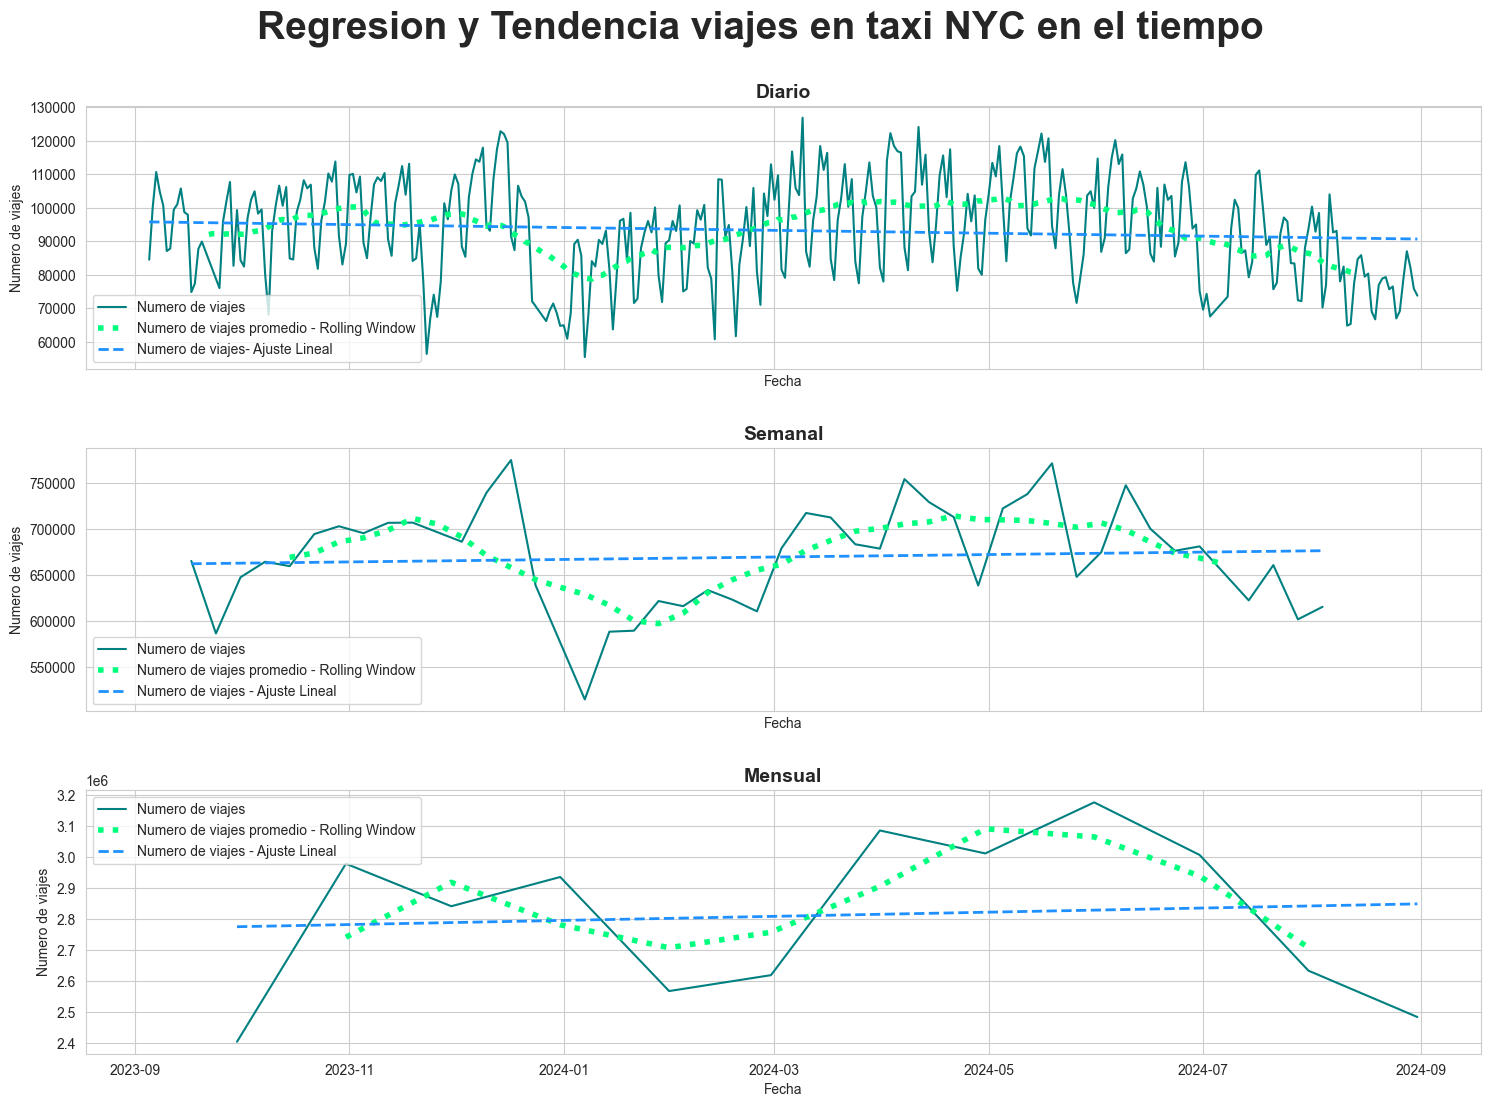

In [ ]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(3,1, figsize = (18,12), gridspec_kw={'height_ratios': [1, 1,1]}, sharex=True)
fig.suptitle("Regresion y Tendencia viajes en taxi NYC en el tiempo",fontsize=28, fontweight='bold')
plt.subplots_adjust(top=0.9,hspace=0.3)

ventana = (35)
diario_promedio_tendencia = diario.n_trips.rolling(window=ventana, center = True).mean()
ax[0].plot(diario.index, diario.n_trips, label = 'Numero de viajes', color='teal')
ax[0].plot(diario_promedio_tendencia, lw = 4, linestyle=":", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[0].plot(diario.index, reg_lineal_d.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 2, linestyle="--", label = 'Numero de viajes- Ajuste Lineal', color='dodgerblue')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Numero de viajes')
ax[0].set_title('Diario',fontsize=14, fontweight='bold')
ax[0].legend()

ventana = (9)
semanal_promedio_tendencia = semanal.n_trips.rolling(window=ventana, center = True).mean()
ax[1].plot(semanal.index, semanal.n_trips, label = 'Numero de viajes', color='teal')
ax[1].plot(semanal_promedio_tendencia, lw = 4, linestyle=":", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[1].plot(semanal.index, reg_lineal_s.predict(semanal.fecha_numeros.values.reshape(-1, 1)), lw = 2, linestyle="--", label = 'Numero de viajes - Ajuste Lineal', color='dodgerblue')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Numero de viajes')
ax[1].set_title('Semanal',fontsize=14, fontweight='bold')
ax[1].legend()

ventana = (3)
mensual_promedio_tendencia = mensual.n_trips.rolling(window=ventana, center = True).mean()
ax[2].plot(mensual.index, mensual.n_trips, label = 'Numero de viajes', color='teal')
ax[2].plot(mensual_promedio_tendencia, lw = 4, linestyle=":", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[2].plot(mensual.index, reg_lineal_m.predict(mensual.fecha_numeros.values.reshape(-1, 1)), lw = 2, linestyle="--", label = 'Numero de viajes - Ajuste Lineal', color='dodgerblue')
ax[2].set_xlabel('Fecha')
ax[2].set_ylabel('Numero de viajes')
ax[2].set_title('Mensual',fontsize=14, fontweight='bold')
ax[2].legend()

plt.show()

## Frecuencia Mensual

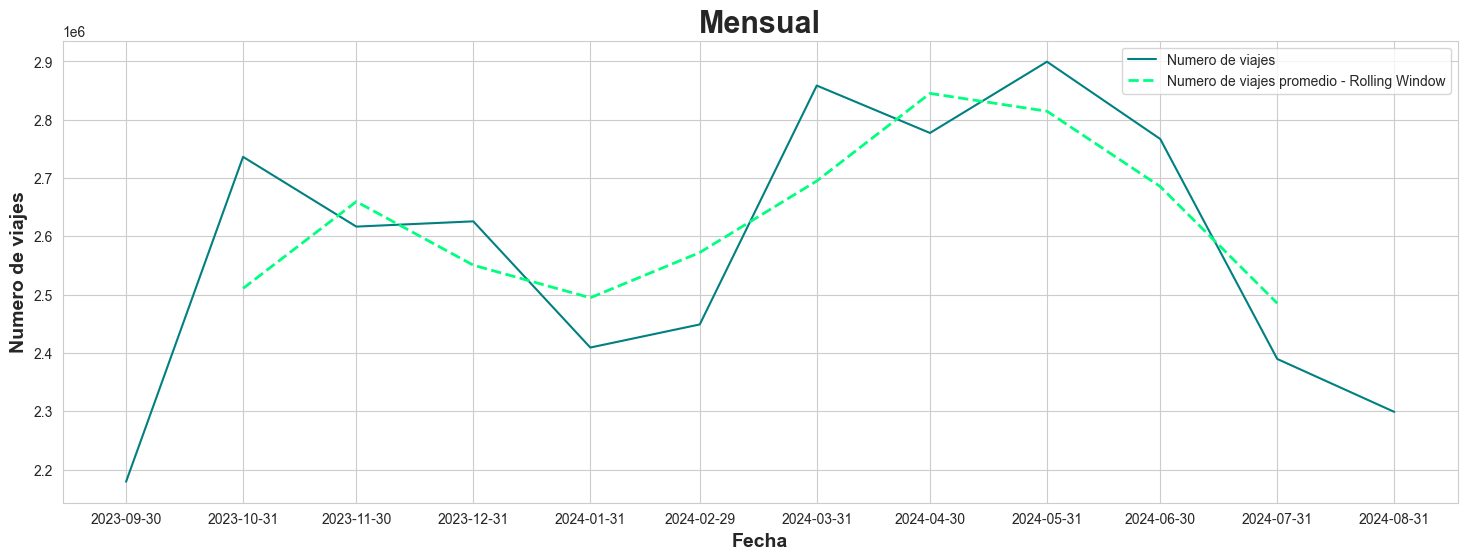

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(18,6))

ventana = (3)
mensual_promedio_tendencia = mensual.n_trips.rolling(window=ventana, center = True).mean()
plt.plot(mensual.index, mensual.n_trips, label = 'Numero de viajes', color='teal')
plt.plot(mensual_promedio_tendencia, lw = 2, linestyle="--", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
plt.xlabel('Fecha',fontsize=14, fontweight='bold')
plt.ylabel('Numero de viajes',fontsize=14, fontweight='bold')
plt.xticks(ticks=mensual.index)
plt.title('Mensual',fontsize=22, fontweight='bold')
plt.legend()

In [8]:
mensual['month_diff'] = mensual['n_trips'] - mensual['n_trips'].shift(1)
mensual['month_diff']

pickup_datetime
2023-09-30         NaN
2023-10-31    557189.0
2023-11-30   -119632.0
2023-12-31      9011.0
2024-01-31   -216426.0
2024-02-29     39610.0
2024-03-31    409709.0
2024-04-30    -81299.0
2024-05-31    122177.0
2024-06-30   -132507.0
2024-07-31   -377281.0
2024-08-31    -90750.0
Name: month_diff, dtype: float64

In [9]:
adfuller_test(mensual['month_diff'].dropna())

ADF Test Statistic : -3.937122907985795
p-value : 0.00177800862115977
#Lags Used : 0
Number of Observations Used : 10
Es estacionaria.


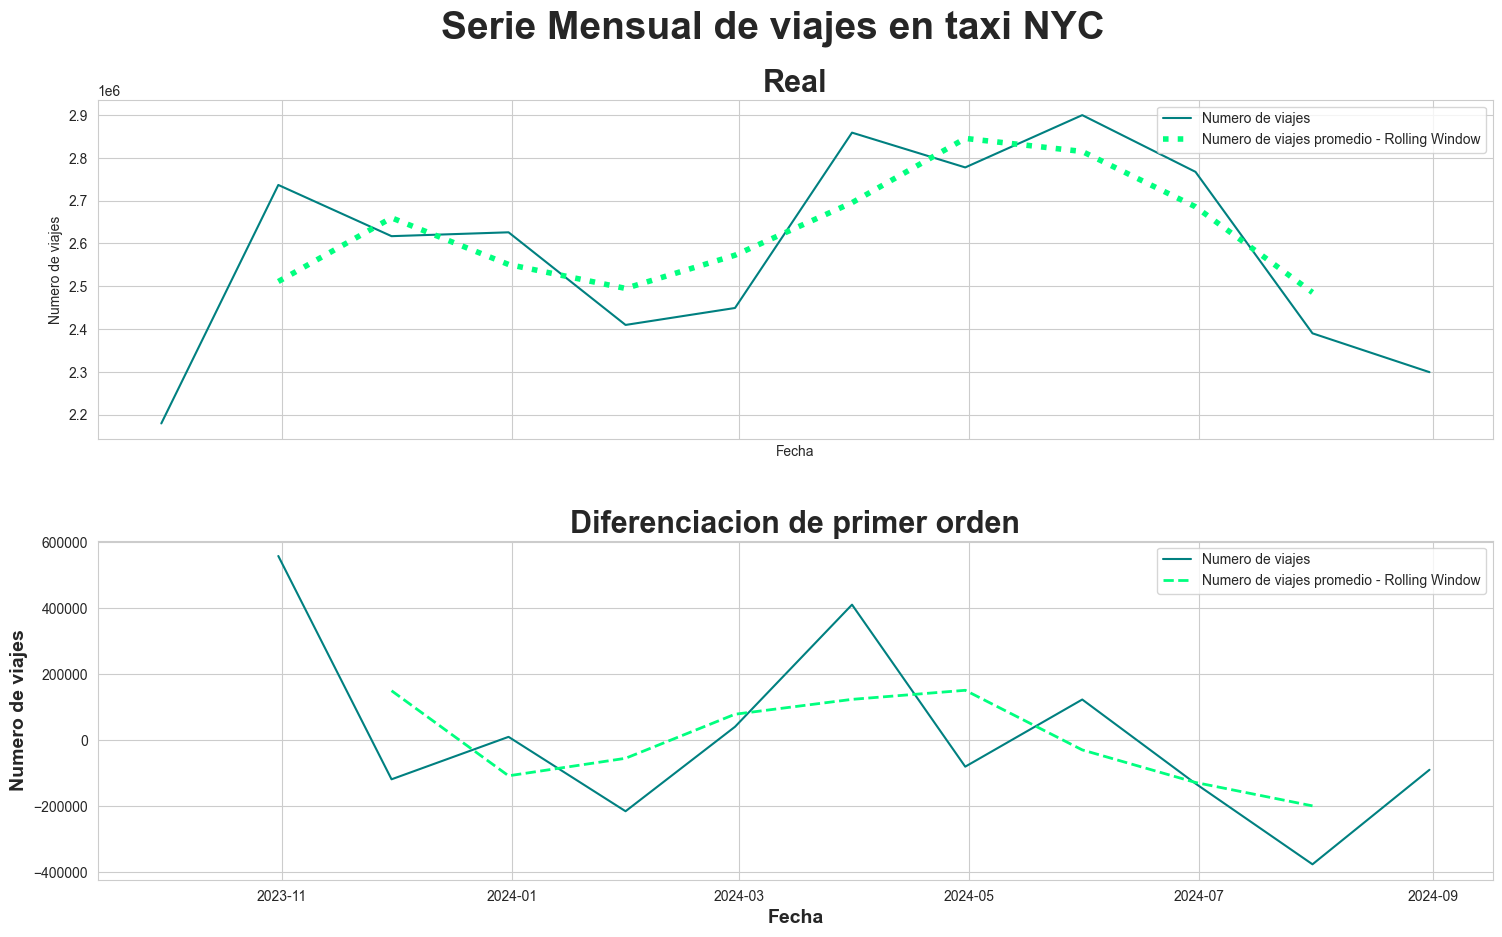

In [10]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2,1, figsize = (18,10), gridspec_kw={'height_ratios': [1,1]}, sharex=True)
fig.suptitle("Serie Mensual de viajes en taxi NYC",fontsize=28, fontweight='bold')
plt.subplots_adjust(top=0.89,hspace=0.3)

ventana = (3)
mensual_promedio_tendencia = mensual.n_trips.rolling(window=ventana, center = True).mean()
ax[0].plot(mensual.index, mensual.n_trips, label = 'Numero de viajes', color='teal')
ax[0].plot(mensual_promedio_tendencia, lw = 4, linestyle=":", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Numero de viajes')
ax[0].set_title('Real',fontsize=22, fontweight='bold')
ax[0].legend()

ventana = (3)
mensual_promedio_tendencia = mensual['month_diff'].rolling(window=ventana, center = True).mean()
ax[1].plot(mensual.index, mensual['month_diff'], label = 'Numero de viajes', color='teal')
ax[1].plot(mensual_promedio_tendencia, lw = 2, linestyle="--", label = 'Numero de viajes promedio - Rolling Window', color='springgreen')
ax[1].set_xlabel('Fecha',fontsize=14, fontweight='bold')
ax[1].set_ylabel('Numero de viajes',fontsize=14, fontweight='bold')
ax[1].set_title('Diferenciacion de primer orden',fontsize=22, fontweight='bold')
ax[1].legend()

plt.show()

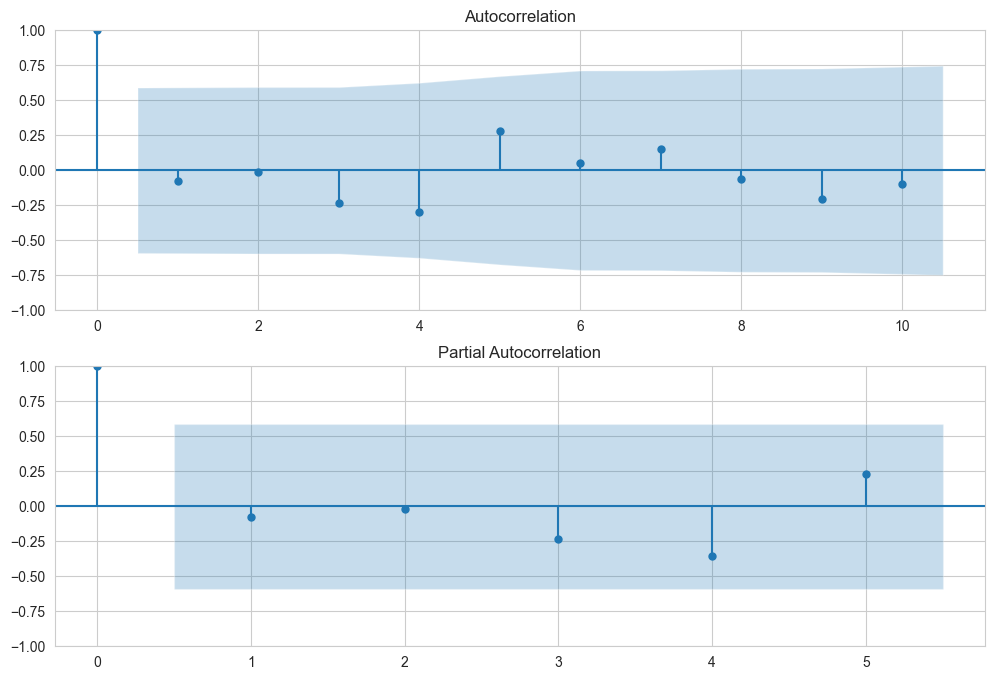

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(mensual['month_diff'].iloc[1:], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(mensual['month_diff'].iloc[1:], lags=5, ax=ax2)
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA

## ARIMA

- p: orden del modelo AR (autoregresivo)
- d: orden de integración (número de diferencias no estacionales)
- q: orden del modelo MA (media móvil)

In [13]:
model = ARIMA(mensual['month_diff'],order=(2,1,1))
model_fit=model.fit()

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             month_diff   No. Observations:                   12
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -155.097
Date:                Tue, 12 Nov 2024   AIC                            318.193
Time:                        23:52:39   BIC                            319.785
Sample:                    09-30-2023   HQIC                           317.190
                         - 08-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3098      0.270     -4.846      0.000      -1.840      -0.780
ar.L2         -0.6906      0.306     -2.259      0.024      -1.290      -0.091
ma.L1          0.9624      0.858      1.121      0.262      -0.720       2.645
sigma2      8.554e+10   1.04e-11   8.22e+21      0.000    8.55e+10    8.55e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.88   Prob(JB):                         0.68
Heteroskedasticity (H):               0.29   Skew:                             0.35
Prob(H) (two-sided):                  0.26   Kurtosis:                         1.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.53e+37. Standard errors may be unstable.
"""

In [14]:
last_date = mensual.index[-1]
forecast=model_fit.predict(start = last_date, end = last_date + pd.DateOffset(months=12), dynamic = True)

In [15]:
forecast_df = pd.DataFrame({'month_diff': forecast}, index=pd.date_range(start=last_date, periods=13, freq='M')[1:])
forecast_df

,month_diff
2024-09-30,-286758.732052
2024-10-31,-230628.585407
2024-11-30,-161043.864110
2024-12-31,-287201.644574
2025-01-31,-175788.005754
2025-02-28,-229881.040287
2025-03-31,-237960.759899
2025-04-30,-190740.255050
2025-05-31,-244741.976996
2025-06-30,-208987.962726


In [16]:
forecast_df

,month_diff
2024-09-30,-286758.732052
2024-10-31,-230628.585407
2024-11-30,-161043.864110
2024-12-31,-287201.644574
2025-01-31,-175788.005754
2025-02-28,-229881.040287
2025-03-31,-237960.759899
2025-04-30,-190740.255050
2025-05-31,-244741.976996
2025-06-30,-208987.962726


In [17]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips,fecha_numeros,month_diff
pickup_datetime,,,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200,738793,NaN
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389,738824,557189.0
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757,738854,-119632.0
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768,738885,9011.0
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342,738916,-216426.0
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952,738945,39610.0
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661,738976,409709.0
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362,739006,-81299.0
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539,739037,122177.0


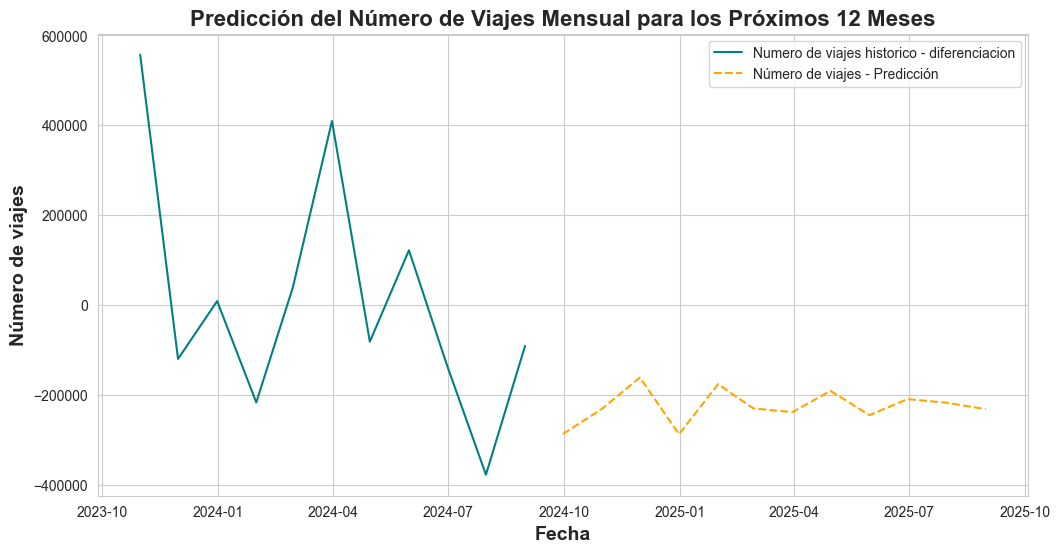

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(mensual.index, mensual['month_diff'], label='Numero de viajes historico - diferenciacion', color='teal')
plt.plot(forecast_df.index,forecast_df['month_diff'] , label='Número de viajes - Predicción', color='orange', linestyle='--')
plt.xlabel('Fecha', fontsize=14, fontweight='bold')
plt.ylabel('Número de viajes', fontsize=14, fontweight='bold')
plt.title('Predicción del Número de Viajes Mensual para los Próximos 12 Meses', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [19]:
# 'differenced_series' es la serie de valores diferenciados
# 'original_series' es la serie original antes de diferenciar

# Valor inicial de la serie (puede ser el primer valor de original_series)
initial_value = mensual['n_trips'].iloc[0]

# Integrar la serie diferenciada usando cumsum
restored_series = mensual['month_diff'].cumsum() + initial_value

# Si estás trabajando con una columna específica de un DataFrame:
mensual['restored_series'] = mensual['month_diff'].cumsum() + mensual['n_trips'].shift(1).fillna(method='bfill')


In [20]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips,fecha_numeros,month_diff,restored_series
pickup_datetime,,,,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200,738793,NaN,NaN
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389,738824,557189.0,2736389.0
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757,738854,-119632.0,3173946.0
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768,738885,9011.0,3063325.0
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342,738916,-216426.0,2855910.0
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952,738945,39610.0,2679094.0
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661,738976,409709.0,3128413.0
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362,739006,-81299.0,3456823.0
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539,739037,122177.0,3497701.0


In [21]:
restored_series = mensual['month_diff'].copy()

restored_series.iloc[0] = mensual['n_trips'].iloc[0]

for i in range(1, len(restored_series)):
    restored_series.iloc[i] = restored_series.iloc[i] + restored_series.iloc[i - 1]

mensual['restored_series'] = restored_series


In [22]:
restored_series = forecast_df['month_diff'].copy()

restored_series.iloc[0] = mensual['n_trips'].iloc[-1]

for i in range(1, len(restored_series)):
    restored_series.iloc[i] = restored_series.iloc[i] + restored_series.iloc[i - 1]

forecast_df['n_trips'] = restored_series

In [23]:
forecast_df

,month_diff,n_trips
2024-09-30,-286758.732052,2.299001e+06
2024-10-31,-230628.585407,2.068372e+06
2024-11-30,-161043.864110,1.907329e+06
2024-12-31,-287201.644574,1.620127e+06
2025-01-31,-175788.005754,1.444339e+06
2025-02-28,-229881.040287,1.214458e+06
2025-03-31,-237960.759899,9.764971e+05
2025-04-30,-190740.255050,7.857568e+05
2025-05-31,-244741.976996,5.410149e+05
2025-06-30,-208987.962726,3.320269e+05


In [24]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips,fecha_numeros,month_diff,restored_series
pickup_datetime,,,,,,,,
2023-09-30,2834965,3460189.95,43351361.13,2.606321e+07,2179200,738793,NaN,2179200.0
2023-10-31,3576133,4382900.21,54676872.61,3.301915e+07,2736389,738824,557189.0,2736389.0
2023-11-30,3427883,4139501.57,51979545.55,3.135258e+07,2616757,738854,-119632.0,2616757.0
2023-12-31,3541070,4167204.54,51955671.11,3.122333e+07,2625768,738885,9011.0,2625768.0
2024-01-31,3104773,3883527.49,46044469.28,2.626918e+07,2409342,738916,-216426.0,2409342.0
2024-02-29,3124501,3959766.71,47253940.40,2.747364e+07,2448952,738945,39610.0,2448952.0
2024-03-31,3628203,4703052.88,55237790.42,3.265720e+07,2858661,738976,409709.0,2858661.0
2024-04-30,3513134,4646128.88,54112655.33,3.226751e+07,2777362,739006,-81299.0,2777362.0
2024-05-31,3665269,4793006.98,57431400.26,3.453748e+07,2899539,739037,122177.0,2899539.0


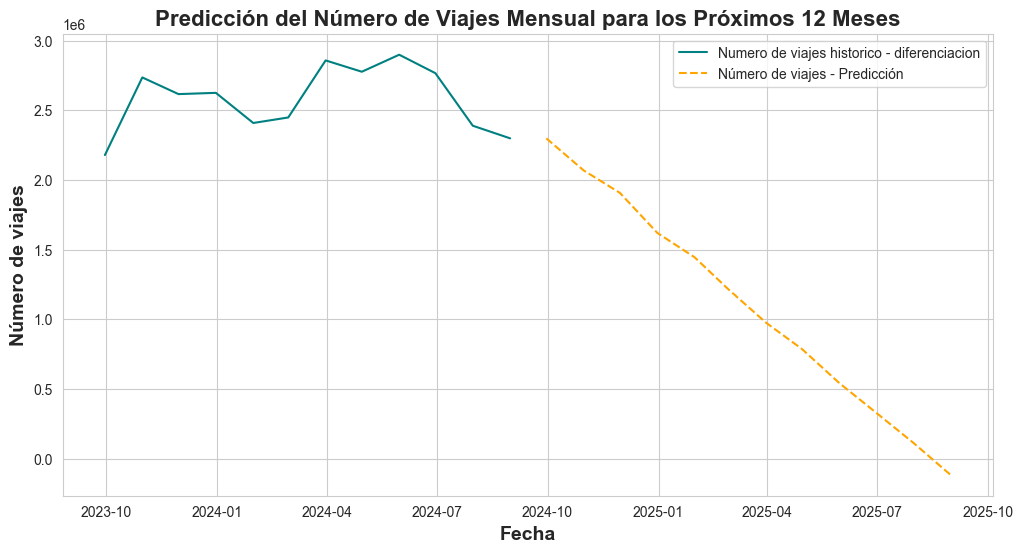

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(mensual.index, mensual['n_trips'], label='Numero de viajes historico - diferenciacion', color='teal')
plt.plot(forecast_df.index,forecast_df['n_trips'] , label='Número de viajes - Predicción', color='orange', linestyle='--')
plt.xlabel('Fecha', fontsize=14, fontweight='bold')
plt.ylabel('Número de viajes', fontsize=14, fontweight='bold')
plt.title('Predicción del Número de Viajes Mensual para los Próximos 12 Meses', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## SARIMA

In [27]:
# Parámetros para SARIMA: p, d, q, P, D, Q, m
p, d, q = 2, 1, 1  # Componentes no estacionales
P, D, Q, m = 1, 1, 1, 12  # Componentes estacionales, con m=12 para indicar una estacionalidad de 12 meses

# Definir el modelo SARIMA
sarima_model = SARIMAX(mensual['month_diff'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Ajustar el modelo SARIMA
sarima_fit = sarima_model.fit(disp=False)

# Generar pronóstico para los próximos 12 meses
last_date = mensual.index[-1]
forecast_steps = 12
sarima_forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Crear DataFrame de predicción con el índice de fechas
forecast_df = sarima_forecast.summary_frame()
forecast_df.index = forecast_index


In [28]:
forecast_df

month_diff,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-09-30,132125.555425,1483.240088,129218.458271,135032.652579
2024-10-31,355001.222288,1673.320663,351721.574054,358280.870521
2024-11-30,-321819.777712,1673.320961,-325099.426531,-318540.128893
2024-12-31,-193176.777712,1673.321260,-196456.427117,-189897.128308
2025-01-31,-418613.777712,1673.321559,-421893.427703,-415334.127722
2025-02-28,-162577.777712,1673.321858,-165857.428288,-159298.127136
2025-03-31,207521.222288,1673.322157,204241.571126,210800.873449
2025-04-30,-283486.777712,1673.322455,-286766.429460,-280207.125965
2025-05-31,-80010.777712,1673.322754,-83290.430045,-76731.125380
2025-06-30,-334694.777712,1673.323053,-337974.430631,-331415.124794


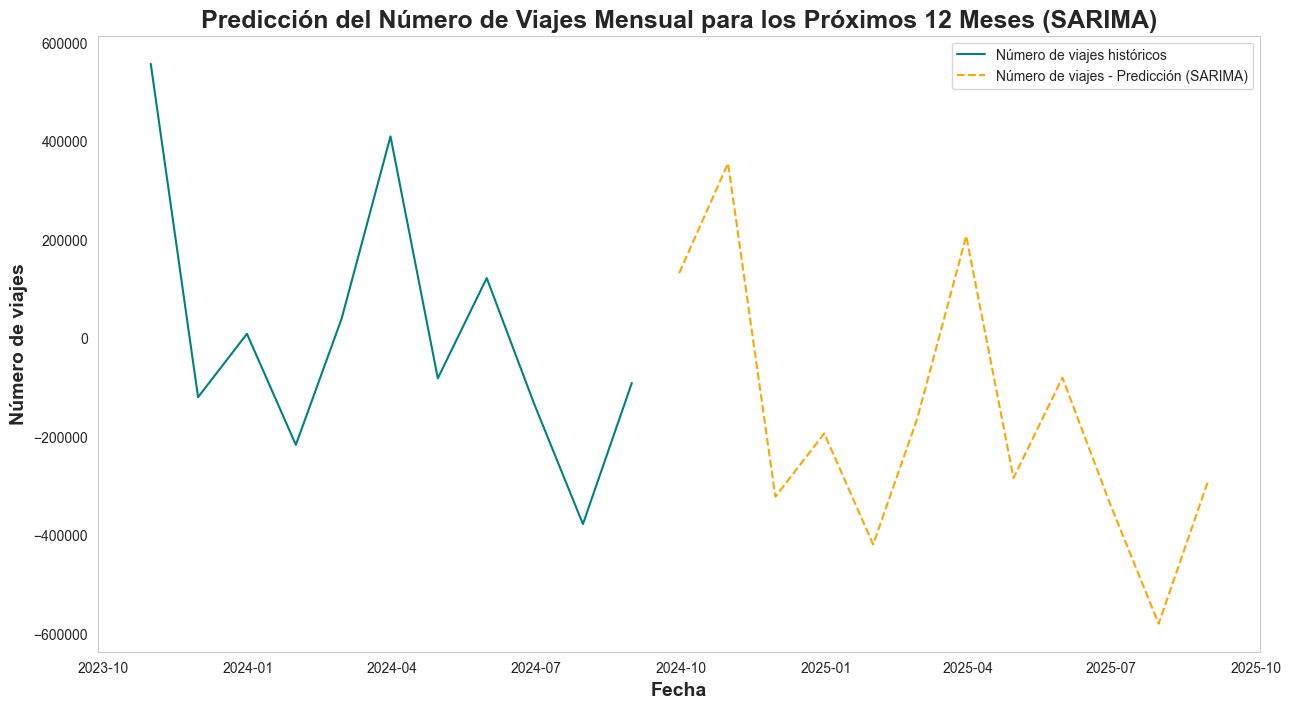

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
plt.plot(mensual.index, mensual['month_diff'], label='Número de viajes históricos', color='teal')
plt.plot(forecast_df.index, forecast_df['mean'], label='Número de viajes - Predicción (SARIMA)', color='orange', linestyle='--')
plt.xlabel('Fecha', fontsize=14, fontweight='bold')
plt.ylabel('Número de viajes', fontsize=14, fontweight='bold')
plt.title('Predicción del Número de Viajes Mensual para los Próximos 12 Meses (SARIMA)', fontsize=18, fontweight='bold')
plt.legend()
plt.grid()
plt.show()

In [31]:
restored_series = forecast_df['mean'].copy()

restored_series.iloc[0] = mensual['n_trips'].iloc[-1]

for i in range(1, len(restored_series)):
    restored_series.iloc[i] = restored_series.iloc[i] + restored_series.iloc[i - 1]

forecast_df['n_trips'] = restored_series

In [32]:
forecast_df

month_diff,mean,mean_se,mean_ci_lower,mean_ci_upper,n_trips
2024-09-30,132125.555425,1483.240088,129218.458271,135032.652579,2.299001e+06
2024-10-31,355001.222288,1673.320663,351721.574054,358280.870521,2.654002e+06
2024-11-30,-321819.777712,1673.320961,-325099.426531,-318540.128893,2.332182e+06
2024-12-31,-193176.777712,1673.321260,-196456.427117,-189897.128308,2.139006e+06
2025-01-31,-418613.777712,1673.321559,-421893.427703,-415334.127722,1.720392e+06
2025-02-28,-162577.777712,1673.321858,-165857.428288,-159298.127136,1.557814e+06
2025-03-31,207521.222288,1673.322157,204241.571126,210800.873449,1.765335e+06
2025-04-30,-283486.777712,1673.322455,-286766.429460,-280207.125965,1.481849e+06
2025-05-31,-80010.777712,1673.322754,-83290.430045,-76731.125380,1.401838e+06
2025-06-30,-334694.777712,1673.323053,-337974.430631,-331415.124794,1.067143e+06


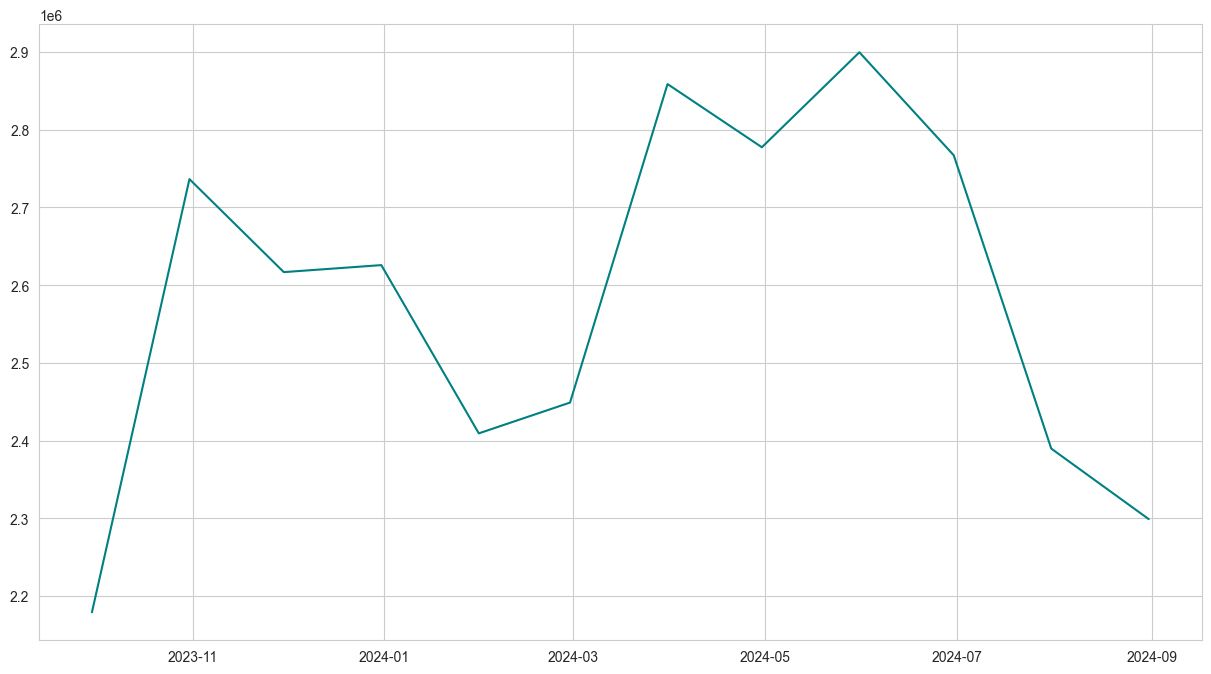

In [37]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
plt.plot(mensual.index, mensual['n_trips'], label='Número de viajes históricos', color='teal')


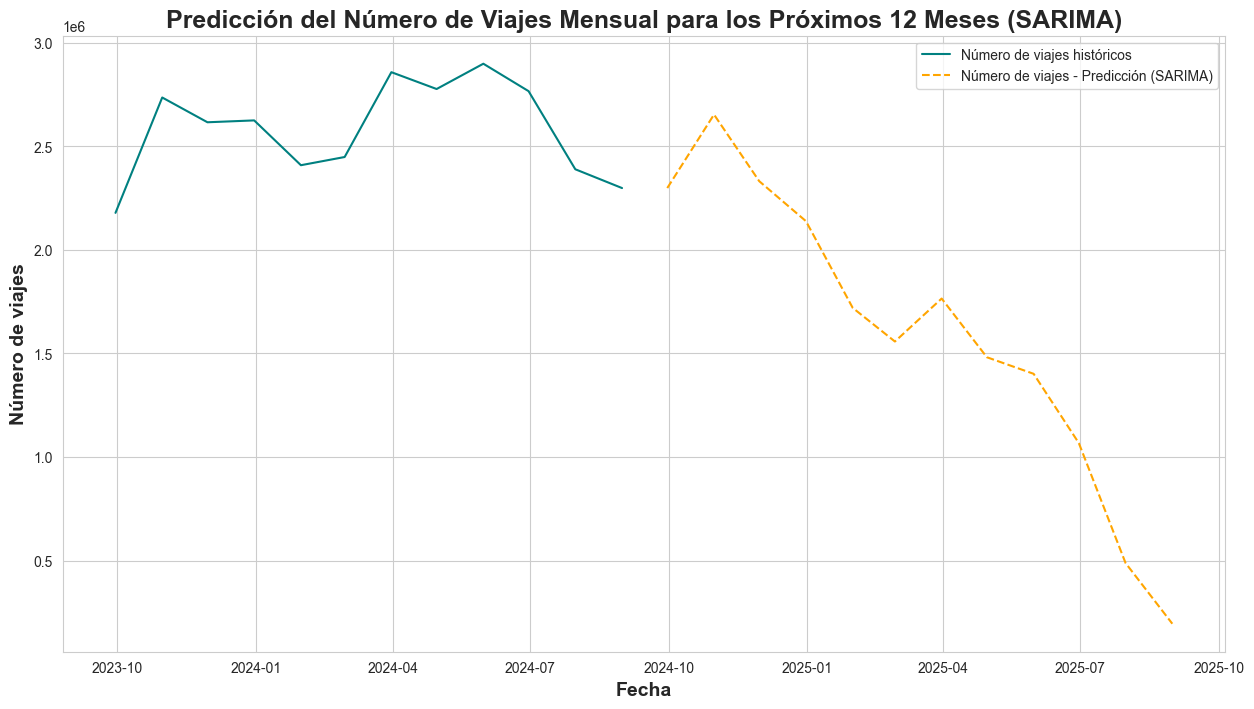

In [38]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
plt.plot(mensual.index, mensual['n_trips'], label='Número de viajes históricos', color='teal')
plt.plot(forecast_df.index, forecast_df['n_trips'], label='Número de viajes - Predicción (SARIMA)', color='orange', linestyle='--')
plt.xlabel('Fecha', fontsize=14, fontweight='bold')
plt.ylabel('Número de viajes', fontsize=14, fontweight='bold')
plt.title('Predicción del Número de Viajes Mensual para los Próximos 12 Meses (SARIMA)', fontsize=18, fontweight='bold')
plt.legend()
plt.show()

## Multi Step

### Recursivo

In [ ]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

## Prophet

In [5]:
from prophet import Prophet

In [6]:
mensual

,passenger_count,trip_distance,total_amount,duration,n_trips,fecha_numeros
pickup_datetime,,,,,,
2023-09-30,2732993,3840800.70,45795129.41,2.875794e+07,2403633.0,738793
2023-10-31,3898868,5472308.86,63778214.48,3.970597e+07,2978961.0,738824
2023-11-30,3726416,5136505.72,60388236.66,3.754072e+07,2841540.0,738854
2023-12-31,3890520,5266948.52,61323166.56,3.819132e+07,2936035.0,738885
2024-01-31,3310266,4670785.61,51801929.35,3.013794e+07,2567477.0,738916
2024-02-29,3341622,4790656.33,53447385.19,3.177544e+07,2618823.0,738945
2024-03-31,3916080,5804068.48,63395507.19,3.847457e+07,3086307.0,738976
2024-04-30,3809875,5778995.02,62516945.41,3.832527e+07,3012148.0,739006
2024-05-31,3988977,5993937.36,66836199.45,4.142039e+07,3177197.5,739037


In [7]:
mensual_p = mensual['n_trips']

In [10]:
mensual_p

,n_trips
pickup_datetime,
2023-09-30,2403633.0
2023-10-31,2978961.0
2023-11-30,2841540.0
2023-12-31,2936035.0
2024-01-31,2567477.0
2024-02-29,2618823.0
2024-03-31,3086307.0
2024-04-30,3012148.0
2024-05-31,3177197.5


In [14]:
mensual_p = mensual_p.reset_index()

In [16]:
mensual_p.rename(columns= {'pickup_datetime': 'ds', 'n_trips' : 'y'}, inplace = True)
mensual_p

,ds,y
0,2023-09-30,2403633.0
1,2023-10-31,2978961.0
2,2023-11-30,2841540.0
3,2023-12-31,2936035.0
4,2024-01-31,2567477.0
5,2024-02-29,2618823.0
6,2024-03-31,3086307.0
7,2024-04-30,3012148.0
8,2024-05-31,3177197.5
9,2024-06-30,3007364.0


In [19]:
# Instanciamos un modelo de Prophet

prophet = Prophet(yearly_seasonality= True, uncertainty_samples = 20, mcmc_samples=20, interval_width= 0.5)

# Entrenamos el modelo
prophet.fit(mensual_p)

# Construimos un dataframe con los x valores futuros que querámos predecir. En este caso, 4 años.
build_forecast = prophet.make_future_dataframe(periods=12, freq='M') #

# Predecimos
forecast = prophet.predict(build_forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3k5_54x0/0hlr6mqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3k5_54x0/xo6n8k01.json
06:53:56 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=50820', 'data', 'file=/tmp/tmp3k5_54x0/0hlr6mqa.json', 'init=/tmp/tmp3k5_54x0/xo6n8k01.json', 'output', 'file=/tmp/tmp3k5_54x0/prophet_model6o3nalm1/prophet_model-20241113065357_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=50820', 'data', 'file=/tmp/tmp3k5_54x0/0hlr6mqa.json', 'init=/tmp/tmp3k5_54x0/xo6n8k01.json', 'output', 'file=/tmp/tmp3k5_54x0/prophet_model6o3nalm1/prophet_model-20241113065357_2.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

06:53:57 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=50820', 'data', 'file=/tmp/tmp3k5_54x0/0hlr6mqa.json', 'init=/tmp/tmp3k5_54x0/xo6n8k01.json', 'output', 'file=/tmp/tmp3k5_54x0/prophet_model6o3nalm1/prophet_model-20241113065357_1.csv', 'method=sample', 'num_samples=10', 'num_warmup=10', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp3k5_54x0/prophet_model6o3nalm1/prophet_model-20241113065357_1.csv
 console_msgs (if any):
	/tmp/tmp3k5_54x0/prophet_model6o3nalm1/prophet_model-20241113065357_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 10
    num_warmup = 10
    save_warmup = 0 (Default)
    thin = 1 (Default)


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [20]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-30,6.641326e+06,1.649626e+06,3.784907e+06,2.102840e+06,1.084970e+07,-3.814708e+06,-8.637593e+06,1.295898e+06,-3.814708e+06,-8.637593e+06,1.295898e+06,0.0,0.0,0.0,2.826617e+06
1,2023-10-31,5.902125e+06,1.592338e+06,4.365997e+06,2.169345e+06,9.535703e+06,-2.901234e+06,-6.944706e+06,7.320411e+05,-2.901234e+06,-6.944706e+06,7.320411e+05,0.0,0.0,0.0,3.000891e+06
2,2023-11-30,5.187701e+06,1.691590e+06,3.413871e+06,2.138648e+06,8.228356e+06,-2.688678e+06,-5.370261e+06,2.412310e+05,-2.688678e+06,-5.370261e+06,2.412310e+05,0.0,0.0,0.0,2.499023e+06
3,2023-12-31,4.455463e+06,1.172234e+06,3.924853e+06,2.361576e+06,6.651329e+06,-1.787403e+06,-3.588648e+06,1.928665e+05,-1.787403e+06,-3.588648e+06,1.928665e+05,0.0,0.0,0.0,2.668060e+06
4,2024-01-31,3.724082e+06,1.698374e+06,4.056725e+06,2.740292e+06,4.797388e+06,-1.062016e+06,-2.159872e+06,6.046149e+05,-1.062016e+06,-2.159872e+06,6.046149e+05,0.0,0.0,0.0,2.662066e+06
5,2024-02-29,3.042013e+06,1.149263e+06,3.143527e+06,2.381348e+06,3.477549e+06,-5.175046e+05,-1.057533e+06,5.426279e+05,-5.175046e+05,-1.057533e+06,5.426279e+05,0.0,0.0,0.0,2.524509e+06
6,2024-03-31,2.312516e+06,1.519504e+06,4.888138e+06,1.844090e+06,2.934370e+06,1.006485e+06,1.372364e+05,1.705853e+06,1.006485e+06,1.372364e+05,1.705853e+06,0.0,0.0,0.0,3.319002e+06
7,2024-04-30,1.604074e+06,2.382593e+06,4.204655e+06,4.843123e+05,2.522294e+06,1.577217e+06,6.249439e+05,2.640701e+06,1.577217e+06,6.249439e+05,2.640701e+06,0.0,0.0,0.0,3.181291e+06
8,2024-05-31,8.734416e+05,2.933025e+06,4.166396e+06,-1.504597e+06,2.675809e+06,2.711593e+06,1.045878e+06,4.015792e+06,2.711593e+06,1.045878e+06,4.015792e+06,0.0,0.0,0.0,3.585035e+06
9,2024-06-30,1.542143e+05,1.275779e+06,3.292409e+06,-2.916408e+06,2.741476e+06,2.978240e+06,4.723345e+05,5.232375e+06,2.978240e+06,4.723345e+05,5.232375e+06,0.0,0.0,0.0,3.132455e+06


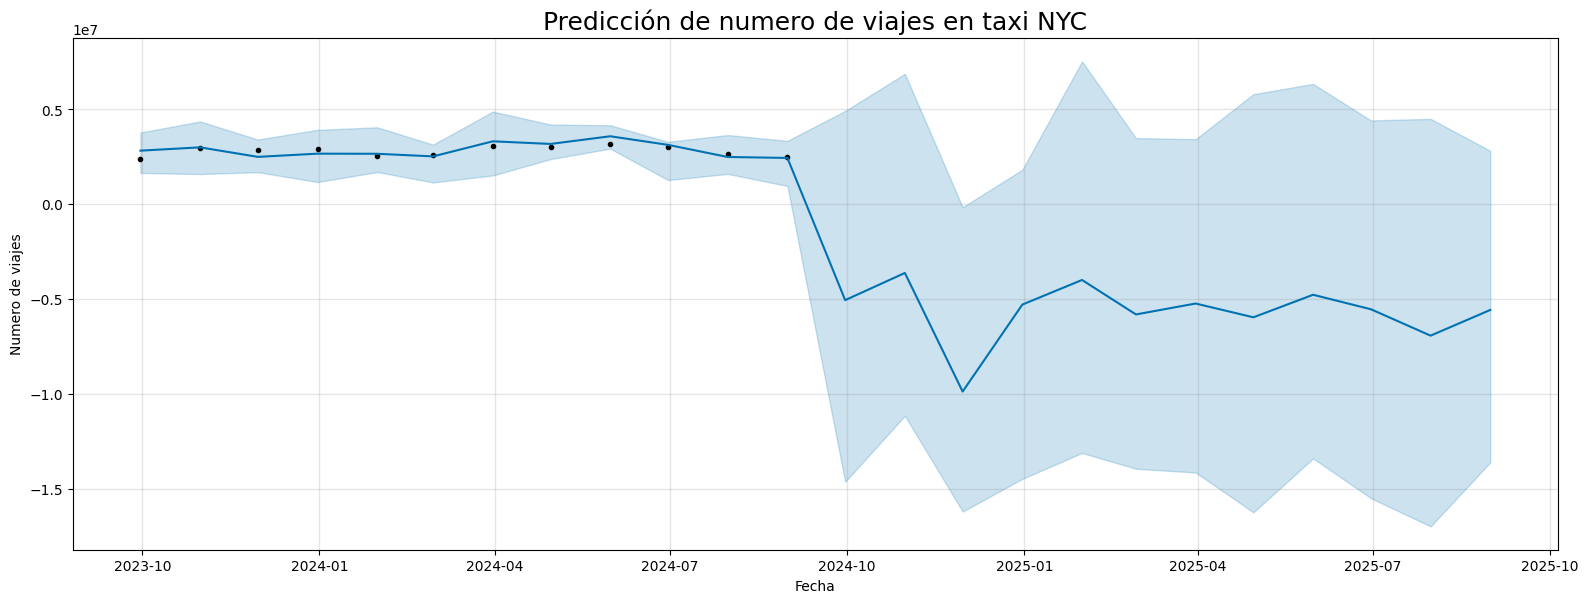

In [21]:
# plot forecasts

prophet.plot(forecast, xlabel='Fecha', ylabel='Numero de viajes', figsize = (16,6))
plt.title('Predicción de numero de viajes en taxi NYC', fontsize = 18)
plt.show()

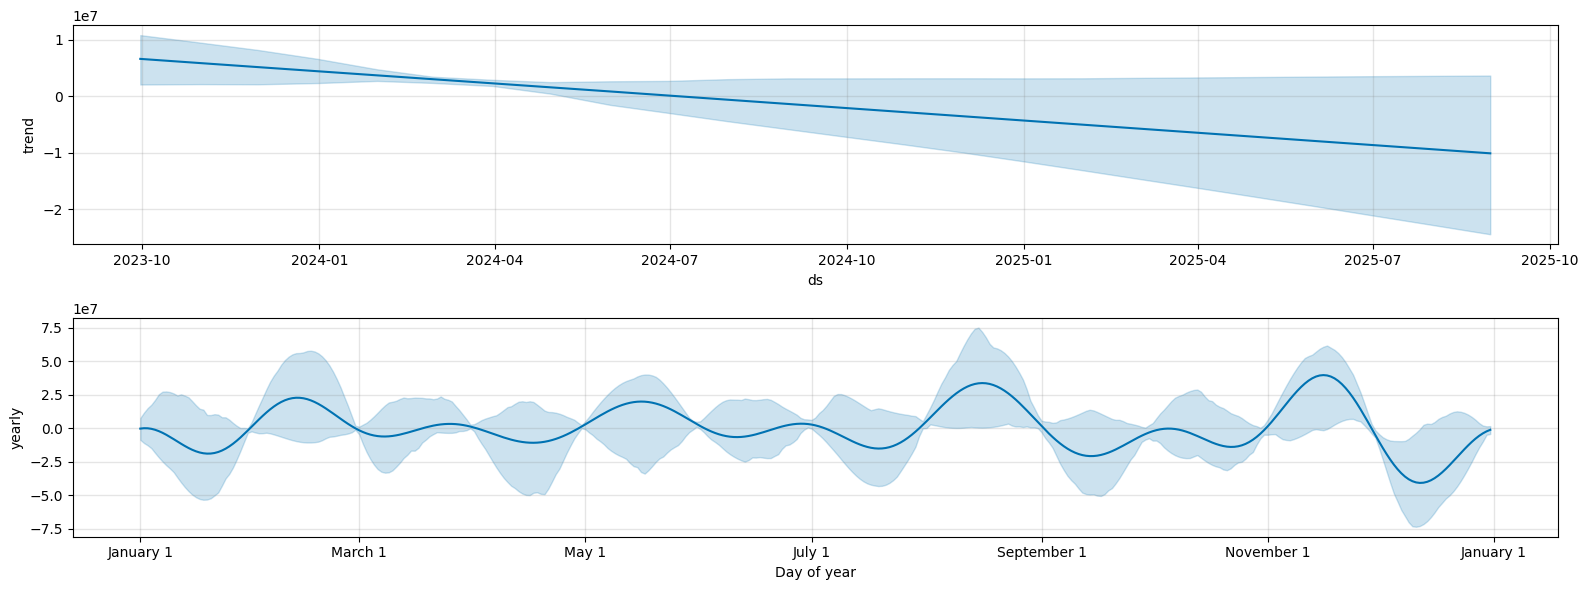

In [22]:
# Ploteamos los componentes de nuestra serie de tiempo

components = prophet.plot_components(forecast, figsize=(16,6))